In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

class GridWorld:
    def __init__(self, size=10, obstacles_prob=0.2):
        self.size = size
        self.obstacles_prob = obstacles_prob
        self.actions = [(0,1),(1,0),(0,-1),(-1,0)]  # R,D,L,U
        self.n_actions = 4

        self.reset_env()

    def reset_env(self):
        self.grid = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(self.size):
                if random.random() < self.obstacles_prob:
                    self.grid[i][j] = -1  # obstacle

        self.start = (0, 0)
        self.goal = (self.size-1, self.size-1)

        self.grid[self.start] = 0
        self.grid[self.goal] = 0

    def reset(self):
        self.agent = self.start
        return self._state(self.agent)

    def _state(self, pos):
        return pos[0] * self.size + pos[1]

    def step(self, action):
        dx, dy = self.actions[action]
        x, y = self.agent
        nx, ny = x + dx, y + dy

        if 0 <= nx < self.size and 0 <= ny < self.size and self.grid[nx][ny] != -1:
            self.agent = (nx, ny)

        reward = -0.01
        done = False

        if self.agent == self.goal:
            reward = 1
            done = True

        return self._state(self.agent), reward, done


In [2]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.7, gamma=0.99, eps=1.0, eps_min=0.05, eps_decay=0.995):
        self.q = np.zeros((n_states, n_actions))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.n_actions = n_actions

    def choose_action(self, state):
        if random.random() < self.eps:
            return random.randint(0, self.n_actions-1)
        return np.argmax(self.q[state])

    def update(self, s, a, r, s2, done):
        target = r if done else r + self.gamma * np.max(self.q[s2])
        self.q[s][a] += self.lr * (target - self.q[s][a])
        self.eps = max(self.eps_min, self.eps * self.eps_decay)


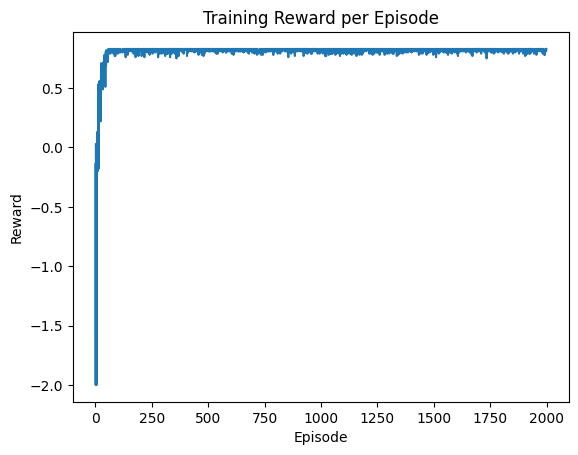

In [3]:
env = GridWorld(size=10, obstacles_prob=0.2)
agent = QLearningAgent(env.size * env.size, env.n_actions)

episodes = 2000
rewards = []

for ep in range(episodes):
    s = env.reset()
    total_r = 0

    for _ in range(200):
        a = agent.choose_action(s)
        s2, r, done = env.step(a)
        agent.update(s, a, r, s2, done)

        s = s2
        total_r += r
        if done:
            break

    rewards.append(total_r)

plt.plot(rewards)
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


In [4]:
def extract_path(env, agent):
    s = env.reset()
    path = [env.start]

    for _ in range(200):
        a = np.argmax(agent.q[s])
        s, _, done = env.step(a)
        pos = (s // env.size, s % env.size)
        path.append(pos)
        if done:
            break

    return path

path = extract_path(env, agent)
path


[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (8, 2),
 (8, 3),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9)]

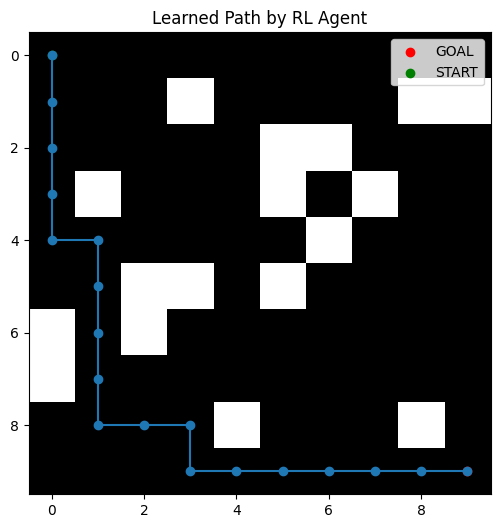

In [11]:
def plot_path(env, path):
    grid = env.grid.copy()
    plt.figure(figsize=(6,6))
    plt.imshow(grid == -1, cmap='gray')
    px = [p[1] for p in path]
    py = [p[0] for p in path]
    plt.plot(px, py, marker='o')
    plt.scatter(env.goal[1], env.goal[0], c='red', label="GOAL")
    plt.scatter(env.start[1], env.start[0], c='green', label="START")
    plt.legend()
    plt.title("Learned Path by RL Agent")
    plt.show()

plot_path(env, path)
